Andy Tzanidakis\
Dec. 13th
LSDB **main**, TAPE **main**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb

In [3]:
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [4]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

CPU times: user 3.09 s, sys: 308 ms, total: 3.4 s
Wall time: 3.42 s


In [5]:
%%time
# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 51.7 s, sys: 8.69 s, total: 1min
Wall time: 1min


## Cone Search

In [6]:
%%time
ra, dec = 132.8460000, +11.8140000
rad = 5 # in degrees
_sample = gaia.cone_search(
    ra=ra,
    dec=dec,
    radius=rad,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 150 and nobs_r_ztf_dr14 > 150 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 10 and \
    classprob_dsc_combmod_star_gaia > 0.9"
).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 27.7 s, sys: 39 s, total: 1min 6s
Wall time: 9.57 s


In [40]:
print (f"Number of unique objects in field: {len(_sample.index.unique())}")

Number of unique objects in field: 62457


Text(0, 0.5, 'r')

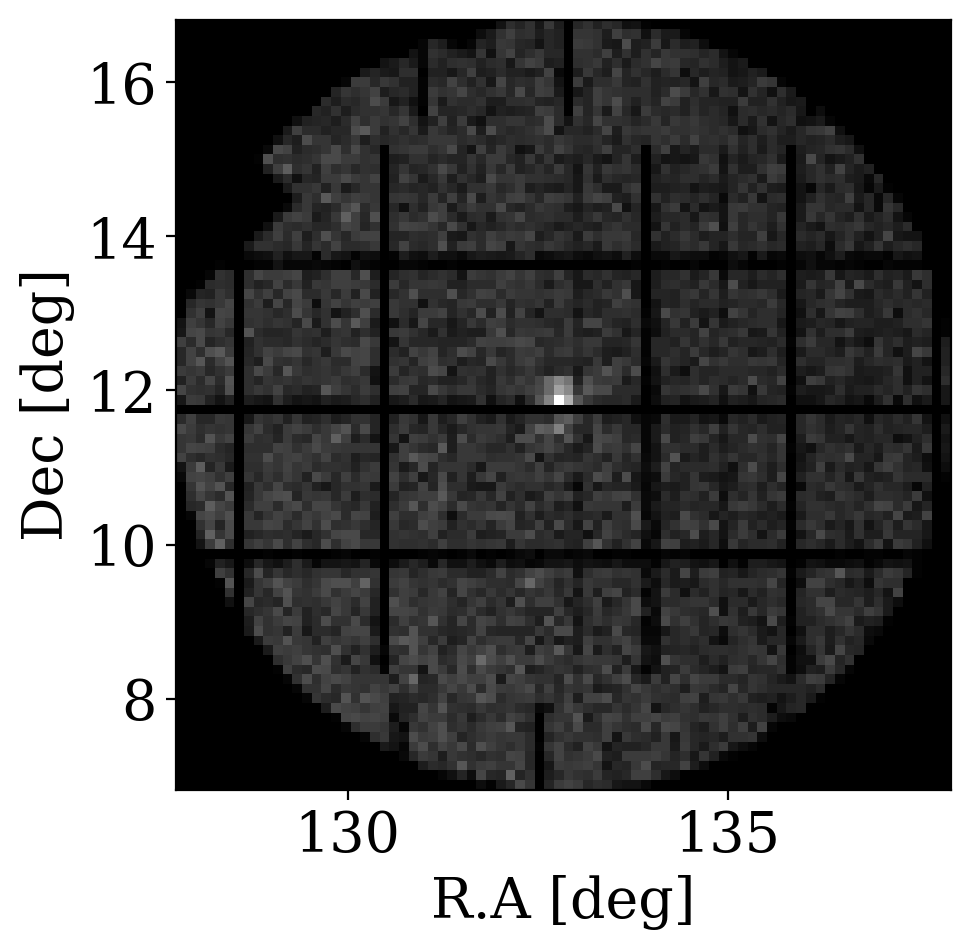

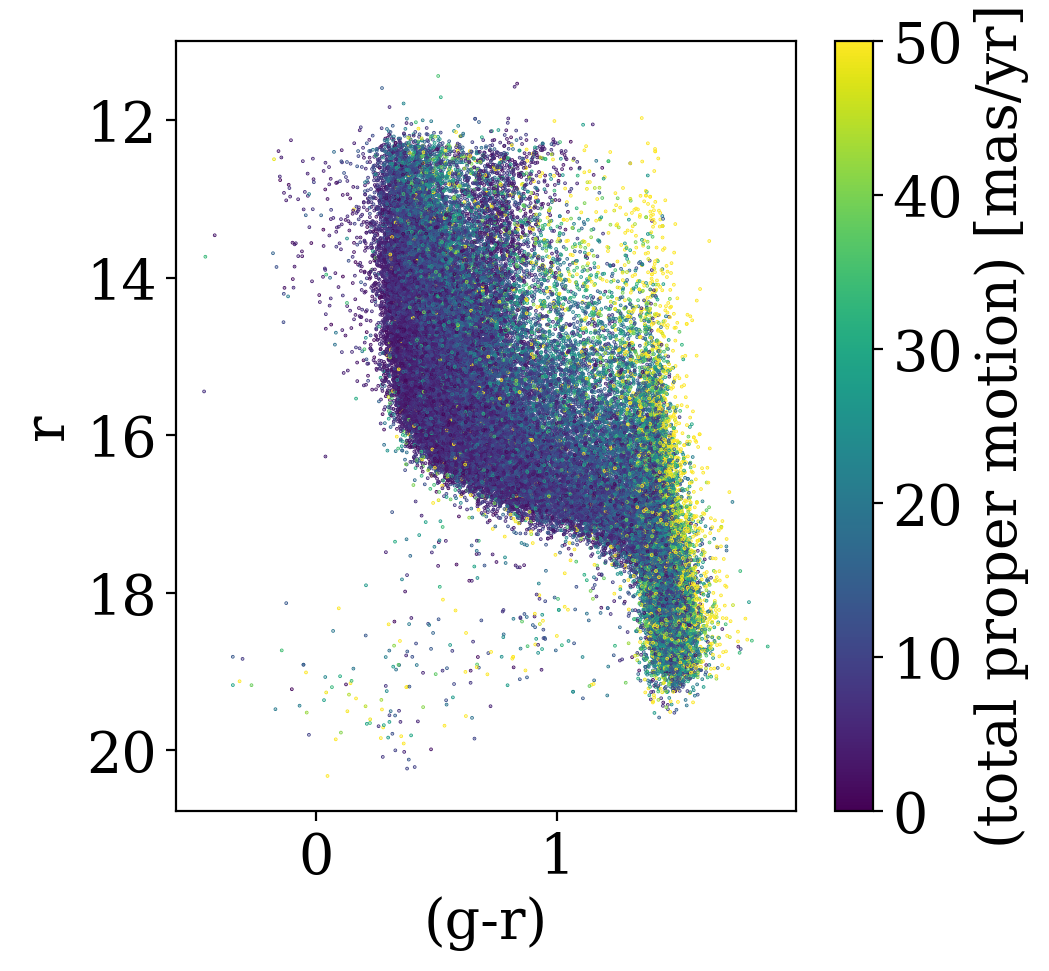

In [38]:
plt.figure(figsize=(5,5))
_ = plt.hist2d(_sample['ra_gaia'], _sample['dec_gaia'], bins=(80, 80), cmap='binary_r')
plt.xlabel("R.A [deg]")
plt.ylabel("Dec [deg]")


plt.figure(figsize=(5,5))
plt.scatter(_sample['mean_mag_g_ztf_dr14']-_sample['mean_mag_r_ztf_dr14'], _sample['mean_mag_r_ztf_dr14'], 
           s=.1, c=np.sqrt(_sample['pmra_gaia']**2 + _sample['pmdec_gaia']**2), 
           vmin=0, vmax=50)
plt.colorbar(label='(total proper motion) [mas/yr]')
plt.gca().invert_yaxis()
plt.xlabel("(g-r)")
plt.ylabel("r")


In [41]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 1.11 s, sys: 45.7 ms, total: 1.15 s
Wall time: 1.16 s


In [45]:
# Load lazy ZTF object + Gaia + Source tacle as hipscat
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

### TAPE

We will now use TAPE to process and compute features for each of our ZTF light curves. TAPE enables fast and scalable methods for writing custom python functions to compute featues for each object. 

In this module I will be building a HR diagram and computing the skewness and kurtosis of each light curve. 

In [47]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [48]:
# Initialize an Ensemble
ens = Ensemble()
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35466 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35466/status,
Dashboard: http://127.0.0.1:35466/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35163,Workers: 12
Dashboard: http://127.0.0.1:35466/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:43121,Total threads: 8
Dashboard: http://127.0.0.1:43334/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:40509,


In [50]:
# ColumnMapper establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_source',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# We can read from parquet
ens.from_dask_dataframe(
    source_frame=ss._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Write Custom Light Curve Function

In [53]:
from astropy.timeseries import LombScargle

def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 
    
    Implemented in https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

    Parameters:
    - x0 (array-like): The input time axis.
    - oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    - nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    - array: The computed optimized periodogram frequency grid.
    """

    # Number of data points in the time series
    num_points = len(x0)

    # Calculate the baseline of the time series
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


# Create a LombScargle Periodogram Model
lsp = LombScargle(phot['mjd'][rf],
                  phot['flux'][rf],
                  phot['flux_err'][rf],
                  fit_mean=True,
                  center_data=True,
                  nterms=1, 
                 normalization='standard')

In [55]:
# Define output columns
output_cols = ["best_period", "best_power", "power_sig"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

def calc_features(time, mag, magerr, flag, band):
    """Calculate the skewness and kurtosis of a light curve for good detections in r-band."""

    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r')
     
    try:
        
        # Create a LombScargle Periodogram Model
        lsp = LombScargle(time,
                          mag,
                          magerr,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power)
        
        return pd.Series(
            [period[np.argmax(power)], power[np.argmax(power)], snr],
            index=output_cols,)
    except:
        return pd.Series([0, 0, 0],index=output_cols,)

In [56]:
%%time
# apply calc_features function
calc_ = ens.batch(
    calc_features,
    'mjd_ztf_source', 'mag_ztf_source', 'magerr_ztf_source', 'catflags_ztf_source','band_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 18.1 ms, sys: 6.77 ms, total: 24.9 ms
Wall time: 22.9 ms


In [57]:
ens.assign(table='object', best_period=calc_['best_period'],
           best_power=calc_['best_power'], 
           power_sig=calc_['power_sig'])

In [58]:
%%time
# compute object table that contains the calculated features... brave decision to run LSP on >50,000 objcets?!
demo = ens.object.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 78.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 6s, sys: 27 s, total: 1min 33s
Wall time: 5min 16s


In [61]:
# remove unwanted NaNs
demo = demo.dropna(subset=['best_period', 'bp_rp_gaia', 'phot_g_mean_mag_gaia', 'best_power'])

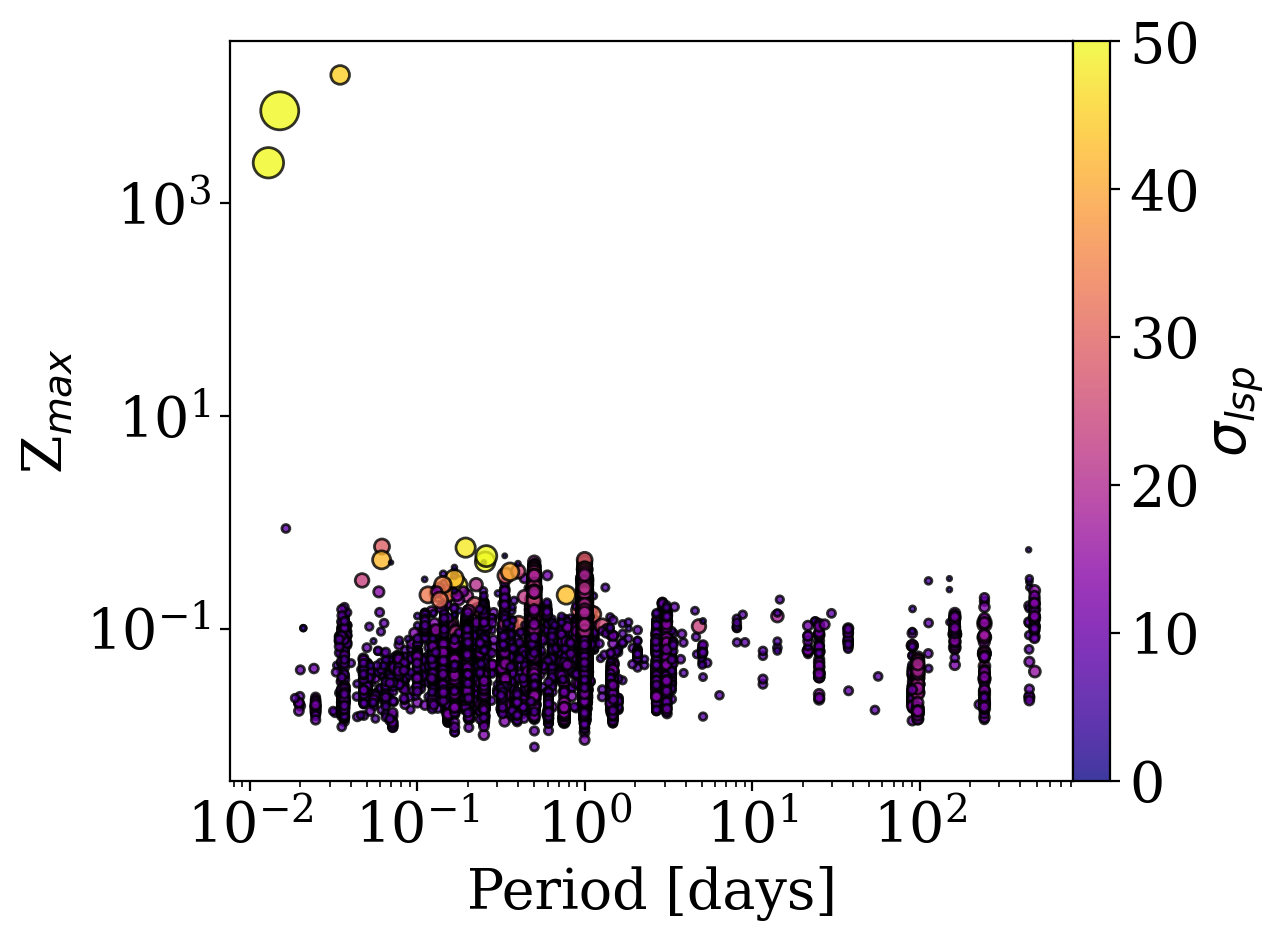

In [83]:
_ = plt.scatter(demo['best_period'],
                demo['best_power'], 
                s=demo['power_sig'], c=demo['power_sig'], vmin=0, vmax=50, 
               cmap='plasma', edgecolor='k', alpha=0.8)

plt.colorbar(label='$\sigma_{lsp}$', pad=1e-4)
plt.xlabel("Period [days]")
plt.ylabel("Z$_{max}$")
plt.yscale('log')
plt.xscale('log')

In [167]:
demo[demo['power_sig']>40].head(1)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,best_period,best_power,power_sig
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,4,0,265,0.000019,5,0,1060,0.254044,0.429471,49.984608


In [187]:
%%time
ens.source.loc[1194365476428316672].compute()

CPU times: user 1.1 s, sys: 472 ms, total: 1.57 s
Wall time: 5.62 s


,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,-32768,518,14.083043,0.013338,58440.44271,13,g,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,0,517,14.021808,0.011313,58434.52177,0,g,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,0,517,13.801671,0.011304,58437.48357,0,g,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,0,518,13.804402,0.013402,58437.50339,13,g,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,-32768,517,14.252253,0.011346,58439.45284,0,g,6,0,4243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,0,517,13.829221,0.012104,58803.33987,0,r,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,-32768,517,13.888218,0.012055,58803.34348,0,r,6,0,4243
1194365476428316672,1636148068921376768,Gaia DR3 597182736851923200,597182736851923200,151013018,2016.0,132.237358,0.013846,8.889873,0.008831,0.204863,...,0,517,14.045745,0.011937,58785.50198,0,r,6,0,4243


In [168]:
demo[demo['power_sig']>40].head(1)['ps1_objid_ztf_dr14']

_hipscat_index
1194365476428316672    118661322373488364
Name: ps1_objid_ztf_dr14, dtype: int64

In [142]:
#ps1_objid_ztf_dr14

In [169]:
lc = ztf_sources.cone_search(ra=132.237358, 
                            dec=8.889873, 
                            radius=0.01).query("ps1_objid == 118661322373488364").compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 42.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [180]:
rr = (lc['band']=='r') & (lc['catflags']==0)
gg = (lc['band']=='g') & (lc['catflags']==0)

In [176]:
# Pending item to be fixed in TAPE
# ens.to_timeseries(1194365476428316672)

(14.355490561574697, 13.735339123755693)

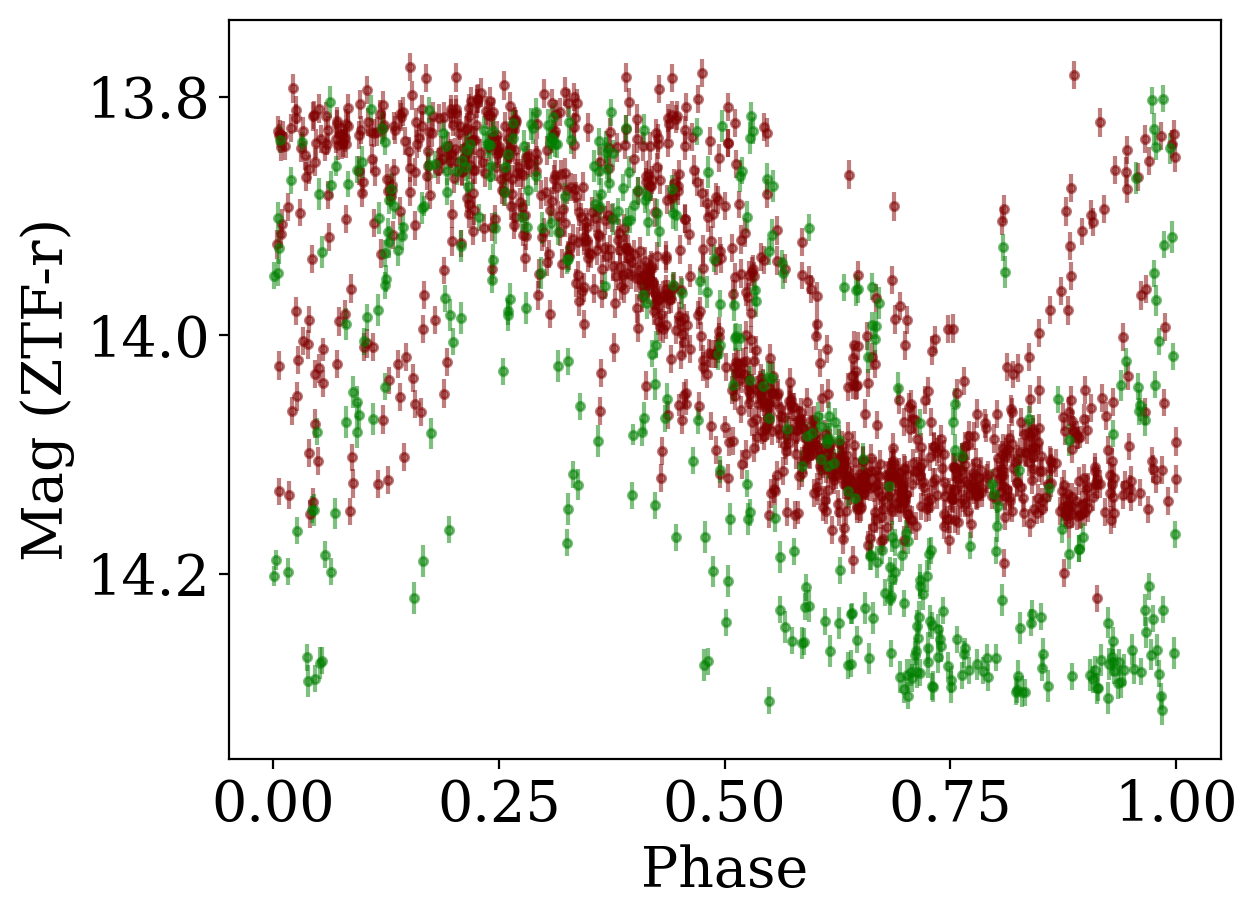

In [183]:
plt.errorbar(lc['mjd'][rr]%0.254044/0.254044, lc['mag'][rr], yerr=lc['magerr'][rr], fmt='.', 
            color='maroon', alpha=0.5)

plt.errorbar(lc['mjd'][gg]%0.254044/0.254044, lc['mag'][gg], yerr=lc['magerr'][gg], fmt='.', 
            color='green', alpha=0.5)
plt.xlabel("Phase")
plt.ylabel("Mag (ZTF-r)")
plt.ylim(plt.ylim()[::-1])